TODO:


- [x] Сделать так чтобы результат выводился в виде нормального полинома, а не sum alpha \* Полинома лежандра
- [ ] Проверить правильность результата, тем более второго задания (график совсем не сходться)

**Задание 1.1.**

Условие ортогональности невязки к базисным векторам запишется в виде:

$\int_a^b {(f(x) - p_n(x)) x^j dx} = 0 \quad \Rightarrow$

$\int_a^b {p_n(x) x^j dx} = \int_a^b {f(x) x^j dx} \quad \Rightarrow$

$\sum_{k=0}^n {\alpha_k \int_a^b {x^{j + k} dx}} = \int_a^b {f(x) x^j dx} \quad \Rightarrow$

$\sum_{k=0}^n {\alpha_k \frac{b^{j+k+1} - a^{j+k+1}}{j+k+1}} = \int_a^b {f(x) x^j dx} \quad \Rightarrow$

In [73]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def f(x):
    return np.sqrt(x**2) + np.log(x**2)

a, b = 1, 6
n = 5 

A = np.zeros((n+1, n+1))
for i in range(n+1):
    for j in range(n+1):
        A[i, j] = (b**(i+j+1) - a**(i+j+1)) / (i+j+1)

b_vec = np.zeros(n+1)
for j in range(n+1):
    def integrand(x):
        return f(x) * x**j
    b_vec[j], _ = integrate.quad(integrand, a, b)

alpha = np.linalg.solve(A, b_vec)

print("Коэффициенты полинома:")
for i, coeff in enumerate(alpha):
    print(f"α_{i} = {coeff:.6f}")

Коэффициенты полинома:
α_0 = -2.702505
α_1 = 4.786422
α_2 = -1.330940
α_3 = 0.291664
α_4 = -0.033892
α_5 = 0.001596


**Задание 1.2.**

In [7]:
import numpy as np
import math
from scipy import integrate
from scipy.special import legendre
from scipy.special import chebyt
import matplotlib.pyplot as plt

class LegendreApproximation:    
    def __init__(self, f, a, b, n, weight_func_vers=1):

        self.f = f
        self.a = a
        self.b = b
        self.n = n
        self._weight_func_vers = weight_func_vers
        if weight_func_vers == 1:
            self.weight_func = lambda x: 1
        elif weight_func_vers == 2:
            self.weight_func = lambda x: 1 / np.sqrt(1 - x**2)
            
        self.coefficients = None
        self.polynomial = None
        
        # Погрешности
        self.absolute_error = None
        
        self.build_polynomial()

    def x_to_t(self, x):
        """Преобразование x ∈ [a, b] -> t ∈ [-1, 1]"""
        return (2*x - (self.a + self.b)) / (self.b - self.a)
    
    def t_to_x(self, t):
        """Преобразование t ∈ [-1, 1] -> x ∈ [a, b]"""
        return (self.b - self.a)/2 * t + (self.a + self.b)/2
    
    def f_t(self, t):
        """Функция f в координатах t"""
        x = self.t_to_x(t)
        return self.f(x)
    
    def weight_t(self, t):
        """Весовая функция в координатах t"""
        x = self.t_to_x(t)
        return self.weight_func(x)

    def build_polynomial(self):
        """Построение полинома наилучшего приближения"""
        self.coefficients = np.zeros(self.n + 1)
        
        for k in range(self.n + 1):
            if self._weight_func_vers == 1:
                Pk = 2**k * math.factorial(k) *legendre(k)
            elif self._weight_func_vers == 2:
                Pk = chebyt(k)
            
            # Вычисляем скалярное произведение (f, φ_k)
            def integrand_f_phi(t):
                return self.f_t(t) * Pk(t) * self.weight_t(t)
            
            integral_f_phi, _ = integrate.quad(integrand_f_phi, -1, 1)
            
            # Вычисляем норму полинома Лежандра (φ_k, φ_k)
            def integrand_phi_phi(t):
                return Pk(t)**2 * self.weight_t(t)
            
            integral_phi_phi, _ = integrate.quad(integrand_phi_phi, -1, 1)
            
            # Коэффициент по формуле: c_k = (f, φ_k) / (φ_k, φ_k)
            self.coefficients[k] = integral_f_phi / integral_phi_phi
        
        # Создаем функцию полинома
        def polynomial(x):
            t = self.x_to_t(x)
            result = np.zeros_like(x)
            for k in range(self.n + 1):
                Pk = legendre(k)
                result += self.coefficients[k] * Pk(t)
            return result
        
        self.polynomial = polynomial
        self._compute_errors()

    def _compute_errors(self):
        """Вычисление погрешностей приближения"""
        # Норма функции f
        def f_squared(x):
            return self.f(x)**2 * self.weight_func(x)
        
        norm_f_sq, _ = integrate.quad(f_squared, self.a, self.b)
        
        # Норма полинома
        def p_squared(x):
            return self.polynomial(x)**2 * self.weight_func(x)
        
        norm_p_sq, _ = integrate.quad(p_squared, self.a, self.b)
        
        # Погрешность наилучшего приближения
        self.absolute_error = np.sqrt(norm_f_sq - norm_p_sq)
    
    def get_errors(self):
        return self.absolute_error
    
    def plot_comparison(self, num_points=1000, show_error=True):
        """Построение графиков сравнения"""
        x_plot = np.linspace(self.a, self.b, num_points)
        f_vals = self.f(x_plot)
        p_vals = self.polynomial(x_plot)
        
        plt.figure(figsize=(15, 5 if show_error else 10))
        
        if show_error:
            plt.subplot(1, 2, 1)
        
        plt.plot(x_plot, f_vals, 'b-', linewidth=2, label=f'f(x)')
        plt.plot(x_plot, p_vals, 'r--', linewidth=2, label=f'p_{self.n}(x)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Аппроксимация функции полиномом {self.n}-й степени')
        plt.legend()
        plt.grid(True)
        
        plt.show()
    
    def print_results(self):
        """Вывод результатов"""
        print("="*60)
        print("РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ")
        print("="*60)
        print(f"Функция: f(x) на отрезке [{self.a}, {self.b}]")
        print(f"Степень полинома: {self.n}")
        print("\nКоэффициенты разложения:")
        print("c_k = (f, φ_k) / (φ_k, φ_k)")
        for i, coeff in enumerate(self.coefficients):
            print(f"  c_{i} = {coeff:.8f}")
        
        abs_error = self.get_errors()
        print(f"\nПогрешности:")
        print(f"  Абсолютная погрешность: E_{self.n}(f) = {abs_error:.8f}")
        
        print("="*60)

    def get_approximation_formula(self):
        """Возвращает строку с формулой полинома"""
        terms = []
        for k in range(self.n + 1):
            if abs(self.coefficients[k]) > 1e-10:  # Игнорируем очень малые коэффициенты
                terms.append(f"{self.coefficients[k]:.6f}·P_{k}(t)")
        
        formula = "p(x) = " + " + ".join(terms)
        formula += f", где t = (2x - {self.a + self.b})/{self.b - self.a}"
        return formula

РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ
Функция: f(x) на отрезке [-1, 1]
Степень полинома: 1

Коэффициенты разложения:
c_k = (f, φ_k) / (φ_k, φ_k)
  c_0 = 0.50000000
  c_1 = 0.00000000

Погрешности:
  Абсолютная погрешность: E_1(f) = 0.62665707

Формула: p(x) = 0.500000·P_0(t), где t = (2x - 0)/2


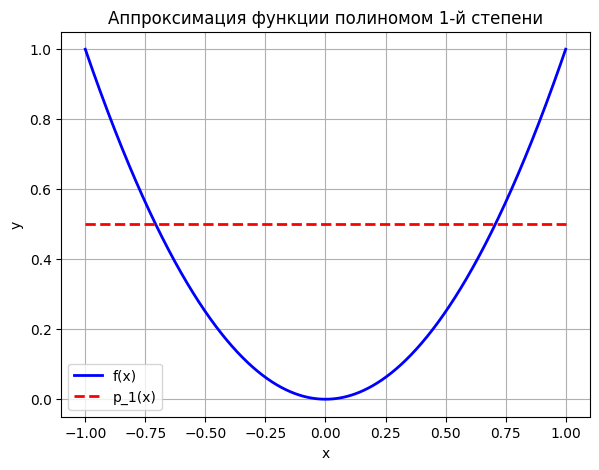

In [8]:
def f(x):
    return x**2

approx2 = LegendreApproximation(f, a=-1, b=1, n=1, weight_func_vers=2)
approx2.print_results()
print(f"\nФормула: {approx2.get_approximation_formula()}")
approx2.plot_comparison()

РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ
Функция: f(x) на отрезке [1, 6]
Степень полинома: 5

Коэффициенты разложения:
c_k = (f, φ_k) / (φ_k, φ_k)
  c_0 = 5.80022273
  c_1 = 2.05993318
  c_2 = -0.05579436
  c_3 = 0.00309682
  c_4 = -0.00013858
  c_5 = 0.00000515

Погрешности:
  Абсолютная погрешность: E_5(f) = 4.62928674

Формула: p(x) = 5.800223·P_0(t) + 2.059933·P_1(t) + -0.055794·P_2(t) + 0.003097·P_3(t) + -0.000139·P_4(t) + 0.000005·P_5(t), где t = (2x - 7)/5


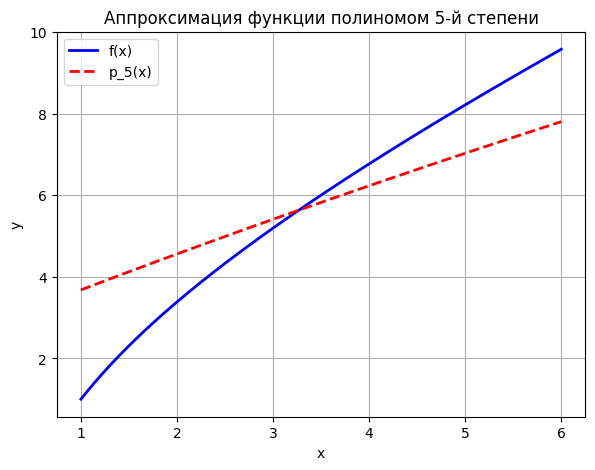

In [72]:
def f(x):
    return np.sqrt(x**2) + np.log(x**2)

a, b = 1, 6
n = 5 

approx2 = LegendreApproximation(f, a=a, b=b, n=n, weight_func_vers=1)
approx2.print_results()
print(f"\nФормула: {approx2.get_approximation_formula()}")
approx2.plot_comparison()

**Задание 2.**

РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ
Функция: f(x) на отрезке [0, 1]
Степень полинома: 10

Коэффициенты разложения:
c_k = (f, φ_k) / (φ_k, φ_k)
  c_0 = 2.02291413
  c_1 = -0.53254401
  c_2 = -0.33152354
  c_3 = 0.35228979
  c_4 = -0.26149316
  c_5 = 0.19304084
  c_6 = -0.14731255
  c_7 = 0.11619274
  c_8 = -0.09419011
  c_9 = 0.07805976
  c_10 = -0.06586546

Погрешности:
  Абсолютная погрешность: E_10(f) = 2.14103961

Формула: p(x) = 2.022914·P_0(t) + -0.532544·P_1(t) + -0.331524·P_2(t) + 0.352290·P_3(t) + -0.261493·P_4(t) + 0.193041·P_5(t) + -0.147313·P_6(t) + 0.116193·P_7(t) + -0.094190·P_8(t) + 0.078060·P_9(t) + -0.065865·P_10(t), где t = (2x - 1)/1


C:\Users\Fanur\AppData\Local\Temp\ipykernel_20088\3503460248.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(x**2) - np.log(x**2)


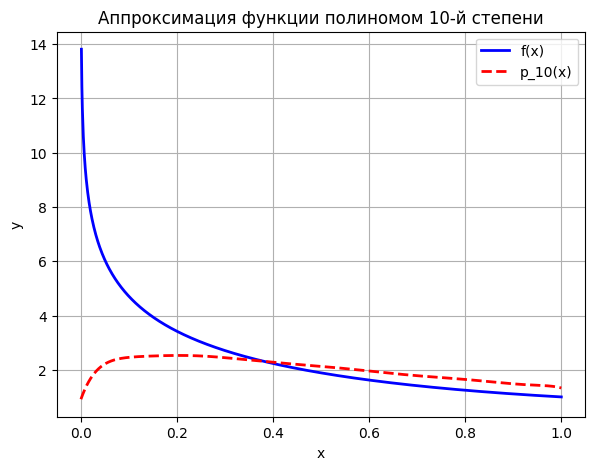

In [62]:
def f(x):
    return np.sqrt(x**2) - np.log(x**2)
    
a = 0
b = 1

approx3 = LegendreApproximation(f, a=a, b=b, n=10, weight_func_vers=2)
approx3.print_results()
print(f"\nФормула: {approx3.get_approximation_formula()}")
approx3.plot_comparison()

---
---
---

In [86]:
import numpy as np
import math
from scipy import integrate
from scipy.special import legendre
from scipy.special import chebyt
import matplotlib.pyplot as plt
import sympy as sp

class LegendreApproximation2:    
    def __init__(self, f, a, b, n, weight_func_vers=1):
        self.f = f
        self.a = a
        self.b = b
        self.n = n
        self._weight_func_vers = weight_func_vers
        
        if weight_func_vers == 1:
            self.weight_func = lambda x: 1
        elif weight_func_vers == 2:
            self.weight_func = lambda x: 1 / np.sqrt(1 - x**2)
            
        self.coefficients = None
        self.polynomial = None
        self.expanded_polynomial = None  # Добавляем атрибут для раскрытого полинома
        self.absolute_error = None
        
        self.build_polynomial()
        self.expand_polynomial()  # Вычисляем раскрытую форму

    def x_to_t(self, x):
        return (2*x - (self.a + self.b)) / (self.b - self.a)
    
    def t_to_x(self, t):
        return (self.b - self.a)/2 * t + (self.a + self.b)/2
    
    def f_t(self, t):
        x = self.t_to_x(t)
        return self.f(x)
    
    def weight_t(self, t):
        x = self.t_to_x(t)
        return self.weight_func(x)

    def build_polynomial(self):
        self.coefficients = np.zeros(self.n + 1)
        
        for k in range(self.n + 1):
            if self._weight_func_vers == 1:
                Pk = 2**k * math.factorial(k) * legendre(k)
            elif self._weight_func_vers == 2:
                Pk = chebyt(k)
            
            def integrand_f_phi(t):
                return self.f_t(t) * Pk(t) * self.weight_t(t)
            
            integral_f_phi, _ = integrate.quad(integrand_f_phi, -1, 1)
            
            def integrand_phi_phi(t):
                return Pk(t)**2 * self.weight_t(t)
            
            integral_phi_phi, _ = integrate.quad(integrand_phi_phi, -1, 1)
            
            self.coefficients[k] = integral_f_phi / integral_phi_phi
        
        def polynomial(x):
            t = self.x_to_t(x)
            result = np.zeros_like(x)
            for k in range(self.n + 1):
                if self._weight_func_vers == 1:
                    Pk = legendre(k)
                elif self._weight_func_vers == 2:
                    Pk = chebyt(k)
                result += self.coefficients[k] * Pk(t)
            return result
        
        self.polynomial = polynomial
        self._compute_errors()

    def expand_polynomial(self):
        def new_leg(k, t_sym):
            return 2**k * math.factorial(k) * sp.legendre(k, t_sym)
        """Раскрывает полином Лежандра в стандартную форму"""
        x_sym = sp.Symbol('x')
        t_sym = sp.Symbol('t')
        
        # Создаем выражение для полинома в переменной t
        poly_t = 0
        for k in range(self.n + 1):
            if abs(self.coefficients[k]) > 1e-10:  # Игнорируем очень малые коэффициенты
                if self._weight_func_vers == 1:
                    # Полином Лежандра в символьной форме
                    Pk_t = new_leg(k, t_sym)
                elif self._weight_func_vers == 2:
                    # Полином Чебышева в символьной форме
                    Pk_t = sp.chebyshevt(k, t_sym)
                poly_t += self.coefficients[k] * Pk_t
        
        # Подставляем t = (2x - (a+b))/(b-a)
        t_expr = (2*x_sym - (self.a + self.b)) / (self.b - self.a)
        poly_x = poly_t.subs(t_sym, t_expr)
        
        # Раскрываем и упрощаем выражение
        self.expanded_polynomial = sp.expand(poly_x)
        
        # Создаем числовую функцию из раскрытого полинома
        self.expanded_polynomial_func = sp.lambdify(x_sym, self.expanded_polynomial, 'numpy')

    def _compute_errors(self):
        def f_squared(x):
            return self.f(x)**2 * self.weight_func(x)
        
        norm_f_sq, _ = integrate.quad(f_squared, self.a, self.b)
        
        def p_squared(x):
            return self.polynomial(x)**2 * self.weight_func(x)
        
        norm_p_sq, _ = integrate.quad(p_squared, self.a, self.b)
        
        self.absolute_error = np.sqrt(norm_f_sq - norm_p_sq)
    
    def evaluate(self, x, expanded=False):
        """Вычисление значения полинома в точке x"""
        if expanded and hasattr(self, 'expanded_polynomial_func'):
            return self.expanded_polynomial_func(x)
        else:
            return self.polynomial(x)
    
    def get_coefficients(self):
        return self.coefficients.copy()
    
    def get_errors(self):
        return self.absolute_error
    
    def get_expanded_coefficients(self):
        """Возвращает коэффициенты раскрытого полинома в стандартном базисе"""
        if hasattr(self, 'expanded_polynomial'):
            x_sym = sp.Symbol('x')
            # Получаем коэффициенты при степенях x
            poly_expr = sp.Poly(self.expanded_polynomial, x_sym)
            coefficients_dict = poly_expr.as_dict()
            
            # Создаем массив коэффициентов
            max_degree = max([monom[0] for monom in coefficients_dict.keys()]) if coefficients_dict else 0
            coeffs_array = np.zeros(max_degree + 1)
            
            for monom, coeff in coefficients_dict.items():
                degree = monom[0]  # степень x
                coeffs_array[degree] = float(coeff)
            
            return coeffs_array
        else:
            return None
    
    def plot_comparison(self, num_points=1000, show_expanded=True):
        """Построение графиков сравнения"""
        x_plot = np.linspace(self.a, self.b, num_points)
        f_vals = self.f(x_plot)
        p_vals = self.polynomial(x_plot)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(x_plot, f_vals, 'b-', linewidth=2, label='f(x)')
        plt.plot(x_plot, p_vals, 'r--', linewidth=2, label=f'p_{self.n}(x)')
        
        if show_expanded and hasattr(self, 'expanded_polynomial_func'):
            p_expanded_vals = self.evaluate(x_plot, expanded=True)
            plt.plot(x_plot, p_expanded_vals, 'g:', linewidth=2, label='p(x) раскрытый')
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Аппроксимация функции полиномом {self.n}-й степени')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        error_vals = f_vals - p_vals
        plt.plot(x_plot, error_vals, 'm-', linewidth=2)
        plt.xlabel('x')
        plt.ylabel('Ошибка')
        plt.title('Погрешность приближения')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def print_results(self):
        """Вывод результатов"""
        print("="*70)
        print("РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ")
        print("="*70)
        print(f"Функция: f(x) на отрезке [{self.a}, {self.b}]")
        print(f"Степень полинома: {self.n}")
        print(f"Весовая функция: версия {self._weight_func_vers}")
        
        print("\nКоэффициенты разложения по ортогональным полиномам:")
        for i, coeff in enumerate(self.coefficients):
            if abs(coeff) > 1e-10:
                print(f"  c_{i} = {coeff:.8f}")
        
        # Вывод раскрытого полинома
        if hasattr(self, 'expanded_polynomial'):
            print(f"\nРаскрытый полином (стандартная форма):")
            print(f"  p_{self.n}(x) = {self.expanded_polynomial}")
            
            # Вывод коэффициентов в стандартном базисе
            expanded_coeffs = self.get_expanded_coefficients()
            if expanded_coeffs is not None:
                print(f"\nКоэффициенты в стандартном базисе:")
                for i, coeff in enumerate(expanded_coeffs):
                    if abs(coeff) > 1e-10:
                        print(f"  x^{i}: {coeff:.8f}")
        
        abs_error = self.get_errors()
        print(f"\nПогрешность: E_{self.n}(f) = {abs_error:.8f}")
        print("="*70)

    def get_approximation_formula(self, expanded=True):
        """Возвращает строку с формулой полинома"""
        if expanded and hasattr(self, 'expanded_polynomial'):
            return f"p_{self.n}(x) = {self.expanded_polynomial}"
        else:
            terms = []
            for k in range(self.n + 1):
                if abs(self.coefficients[k]) > 1e-10:
                    if self._weight_func_vers == 1:
                        terms.append(f"{self.coefficients[k]:.6f}·P_{k}(t)")
                    elif self._weight_func_vers == 2:
                        terms.append(f"{self.coefficients[k]:.6f}·T_{k}(t)")
            formula = "p(x) = " + " + ".join(terms)
            formula += f", где t = (2x - {self.a + self.b})/{self.b - self.a}"
            return formula


РЕЗУЛЬТАТЫ АППРОКСИМАЦИИ
Функция: f(x) на отрезке [0, 1]
Степень полинома: 2
Весовая функция: версия 1

Коэффициенты разложения по ортогональным полиномам:
  c_0 = 0.25000000
  c_1 = 0.22500000
  c_2 = 0.03125000

Раскрытый полином (стандартная форма):
  p_2(x) = 1.5*x**2 - 0.6*x + 0.0499999999999999

Коэффициенты в стандартном базисе:
  x^0: 0.05000000
  x^1: -0.60000000
  x^2: 1.50000000

Погрешность: E_2(f) = 0.25156874

Формула: p_2(x) = 1.5*x**2 - 0.6*x + 0.0499999999999999


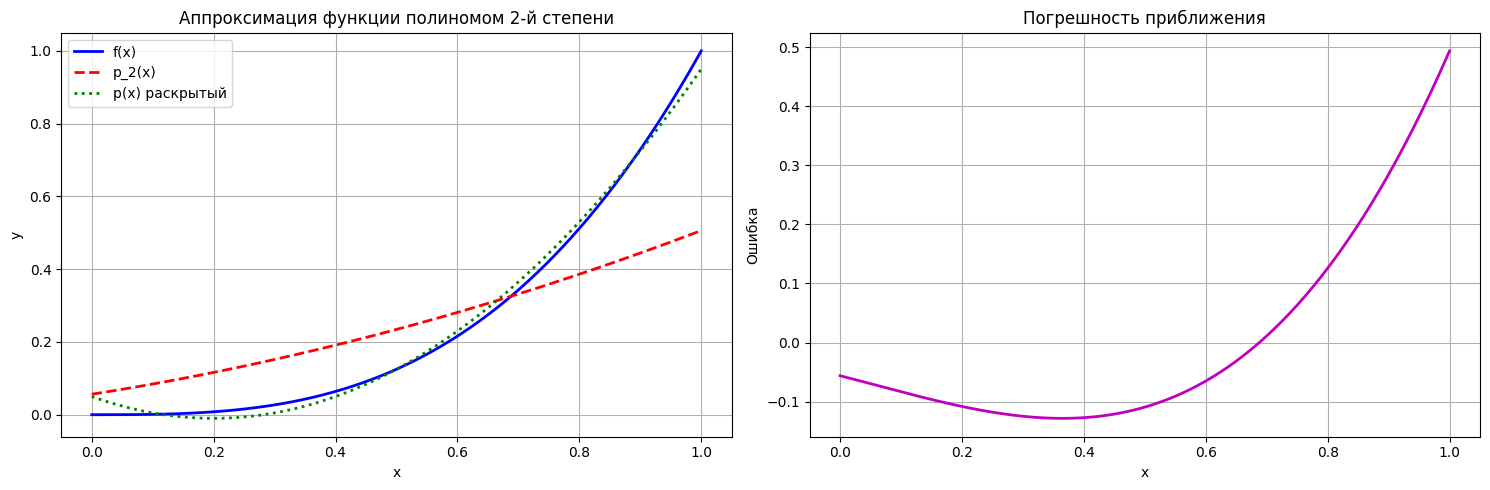

In [87]:
def f(x):
    return x**3

approx4 = LegendreApproximation2(f, a=0, b=1, n=2, weight_func_vers=1)
approx4.print_results()
print(f"\nФормула: {approx4.get_approximation_formula()}")
approx4.plot_comparison()

In [78]:
approx4.expanded_polynomial

0.499999999999964

In [67]:
legendre(1)

poly1d([1., 0.])

In [68]:
legendre(2)

poly1d([ 1.5,  0. , -0.5])

In [70]:
np.array(legendre(2)) + np.array(legendre(1))

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [85]:
x_sym = sp.Symbol('x')

def new_leg(k):
    return 2**k * math.factorial(k) * sp.legendre(k, x_sym)

new_leg(2)

12*x**2 - 4